In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn import metrics
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix

import  shap as shap

In [ ]:


LA_crime = pd.read_csv(r"C:\Users\anton\Desktop\Digethik\04_Projektarbeit\Crime_Data_from_2010_to_2019.csv", sep=",", decimal= ".")

LA_crime.columns = LA_crime.columns.str.replace(' ','_')
LA_crime_raw=LA_crime

# Delete all reports without a defined victim "unpersionalized"
LA_crime.isnull().sum()
LA_crime=LA_crime.drop(LA_crime[LA_crime.Vict_Age <1].index)
LA_crime=LA_crime.drop(LA_crime[LA_crime.Vict_Sex == ""].index)
LA_crime=LA_crime.drop(LA_crime[LA_crime.Vict_Sex == "H"].index)
LA_crime=LA_crime.drop(LA_crime[LA_crime.Vict_Sex == "N"].index)
LA_crime=LA_crime.drop(LA_crime[LA_crime.Vict_Descent == "-"].index)
LA_crime=LA_crime.drop(LA_crime[LA_crime.Vict_Descent == ""].index)
LA_crime=LA_crime[LA_crime['Vict_Descent'].notna()]

#Delete all reports for crime on a private location
private_loc= pd.read_csv(r"C:\Users\anton\Desktop\Digethik\04_Projektarbeit\private_locations.csv", sep=';', header=None)
for row in private_loc[0]:
    LA_crime=LA_crime.drop(LA_crime[LA_crime.Premis_Desc == row].index)
    
# Delete all irrelevant crimes
irrelevant_crimes= pd.read_csv(r"C:\Users\anton\Desktop\Digethik\04_Projektarbeit\irrelevant_crimes.csv", sep=';', header=None)
for row in irrelevant_crimes[0]:
    LA_crime=LA_crime.drop(LA_crime[LA_crime.Crm_Cd_Desc == row].index)

# Metropolitan Transportation Authority MTA
# unite all crimes in public transportation to one general location
LA_crime['Premis_Desc'] = LA_crime.Premis_Desc.str.replace(r'(^.*MTA.*$)', 'PUBLIC_TRANSPORTATION')
LA_crime['Premis_Desc'] = LA_crime.Premis_Desc.str.replace(r'(^.*SUBWAY.*$)', 'PUBLIC_TRANSPORTATION')
LA_crime['Premis_Cd'] = np.where((LA_crime.Premis_Desc == 'PUBLIC_TRANSPORTATION'), 900, LA_crime.Premis_Cd)

# handle no location and no weapon
# delete records where no locarion is recorded
LA_crime = LA_crime[LA_crime['Premis_Desc'].notna()]

#grouping locations to significant
outdoors=["STREET", "SIDEWALK", "PARK/PLAYGROUND", "ALLEY" "OTHER/OUTSIDE", "BEACH"]
vehicle_related=["PARKING LOT", "VEHICLE, PASSENGER/TRUCK", "GARAGE/CARPORT", "DRIVEWAY", "PARKING UNDERGROUND/BUILDING", "GAS STATION"]
publ_transportation=["PUBLIC_TRANSPORTATION", "TRANSPORTATION FACILITY (AIRPORT)", "BUS STOP"]
store=["RESTAURANT/FAST FOOD","MARKET","OTHER STORE","HOTEL","GAS STATION","DRUG STORE","MOTEL","HEALTH SPA/GYM","NIGHT CLUB (OPEN EVENINGS ONLY)","MINI-MART","LIQUOR STORE","LAUNDROMAT","CLOTHING STORE","BAR/COCKTAIL/NIGHTCLUB","SHOPPING MALL (COMMON AREA)","COFFEE SHOP (STARBUCKS, COFFEE BEAN, PEET'S, ETC.)","CELL PHONE STORE","AUTO REPAIR SHOP","BEAUTY/BARBER SHOP","WAREHOUSE","BAR/SPORTS BAR (OPEN DAY & NIGHT)", "DISCOUNT STORE (99 CENT,DOLLAR,ETC."]

LA_crime['Premis_Desc_FILT']=LA_crime['Premis_Desc']
#outdoors=1
LA_crime['Premis_Desc_FILT'] = np.where((LA_crime.Premis_Desc_FILT.isin(outdoors)), 1, LA_crime.Premis_Desc_FILT)
#vehicle_related =2
LA_crime['Premis_Desc_FILT'] = np.where((LA_crime.Premis_Desc_FILT.isin(vehicle_related)), 2, LA_crime.Premis_Desc_FILT)
#publ_transportation =3
LA_crime['Premis_Desc_FILT'] = np.where((LA_crime.Premis_Desc_FILT.isin(publ_transportation)), 3, LA_crime.Premis_Desc_FILT)
#store =4
LA_crime['Premis_Desc_FILT'] = np.where((LA_crime.Premis_Desc_FILT.isin(store)), 4, LA_crime.Premis_Desc_FILT)
#others=0
LA_crime.Premis_Desc_FILT =pd.to_numeric(LA_crime.Premis_Desc_FILT, errors ='coerce').fillna(0)

# grouping crimes to segnificant groups
#theft=1
theft=["ROBBERY", "THEFT PLAIN - PETTY ($950 & UNDER)", "THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)", "THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER)", "INTIMATE PARTNER - SIMPLE ASSAULT", "THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD", "BURGLARY", "THEFT, PERSON", "SHOPLIFTING - PETTY THEFT ($950 & UNDER)", "ATTEMPTED ROBBERY", "BIKE - STOLEN", "THEFT OF IDENTITY", "VEHICLE - ATTEMPT STOLEN", "TRESPASSING", "BURGLARY FROM VEHICLE, ATTEMPTED", "SHOPLIFTING-GRAND THEFT ($950.01 & OVER)", "THEFT FROM MOTOR VEHICLE - ATTEMPT", "PURSE SNATCHING"]
assault=["BATTERY - SIMPLE ASSAULT", "ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT", "INTIMATE PARTNER - SIMPLE ASSAULT", "CRIMINAL THREATS - NO WEAPON DISPLAYED", "BRANDISH WEAPON", "BIKE - STOLEN", "THEFT OF IDENTITY", "BATTERY WITH SEXUAL CONTACT", "INTIMATE PARTNER - AGGRAVATED ASSAULT", "RAPE, FORCIBLE", "OTHER ASSAULT", "INDECENT EXPOSURE", "CRIMINAL HOMICIDE", "THROWING OBJECT AT MOVING VEHICLE", "DISTURBING THE PEACE", "KIDNAPPING"]
vandalism=["VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)", "VANDALISM - MISDEAMEANOR ($399 OR UNDER)"]

LA_crime['Crm_Cd_Desc_FILT']=LA_crime['Crm_Cd_Desc']
#theft=1
LA_crime['Crm_Cd_Desc_FILT'] = np.where((LA_crime.Crm_Cd_Desc_FILT.isin(theft)), 1, LA_crime.Crm_Cd_Desc_FILT)
#assault =2
LA_crime['Crm_Cd_Desc_FILT'] = np.where((LA_crime.Crm_Cd_Desc_FILT.isin(assault)), 2, LA_crime.Crm_Cd_Desc_FILT)
#vandalism =3
LA_crime['Crm_Cd_Desc_FILT'] = np.where((LA_crime.Crm_Cd_Desc_FILT.isin(vandalism)), 3, LA_crime.Crm_Cd_Desc_FILT)
#others=0
LA_crime.Crm_Cd_Desc_FILT =pd.to_numeric(LA_crime.Crm_Cd_Desc_FILT, errors ='coerce').fillna(0)

# define with or without weapon
LA_crime.Weapon_Desc.fillna("NO_WEAPON", inplace=True)
LA_crime['Weapon_Used_Cd_FILT']=LA_crime['Weapon_Used_Cd']
LA_crime['Weapon_Used_Cd_FILT'] = np.where((LA_crime.Weapon_Desc == 'NO_WEAPON'), 0, 1)

# Defining the time into daytime classes
LA_crime.TIME_OCC.apply(pd.to_numeric)
LA_crime['TIME_OCC_FILT']=LA_crime['TIME_OCC']
# night = 1
LA_crime['TIME_OCC_FILT'] = np.where((LA_crime.TIME_OCC_FILT < 600) | (LA_crime.TIME_OCC_FILT >= 1800), 1, LA_crime.TIME_OCC_FILT)
# day = 0
LA_crime['TIME_OCC_FILT'] = np.where((LA_crime.TIME_OCC_FILT >= 600) & (LA_crime.TIME_OCC_FILT < 1800), 0, LA_crime.TIME_OCC_FILT)

# Grouping age classes
LA_crime['Vict_Age_FILT']=LA_crime['Vict_Age']
# <18
LA_crime['Vict_Age_FILT'] = np.where((LA_crime.Vict_Age_FILT < 18), 0, LA_crime.Vict_Age_FILT)
# 19-30
LA_crime['Vict_Age_FILT'] = np.where((LA_crime.Vict_Age_FILT >= 18) & (LA_crime.Vict_Age_FILT < 30), 1, LA_crime.Vict_Age_FILT)
# 31-40
LA_crime['Vict_Age_FILT'] = np.where((LA_crime.Vict_Age_FILT >= 30) & (LA_crime.Vict_Age_FILT < 40), 2, LA_crime.Vict_Age_FILT)
# 41-50
LA_crime['Vict_Age_FILT'] = np.where((LA_crime.Vict_Age_FILT >= 40) & (LA_crime.Vict_Age_FILT < 50), 3, LA_crime.Vict_Age_FILT)
# 51-60
LA_crime['Vict_Age_FILT'] = np.where((LA_crime.Vict_Age_FILT >= 50) & (LA_crime.Vict_Age_FILT < 60), 4, LA_crime.Vict_Age_FILT)
# >60
LA_crime['Vict_Age_FILT'] = np.where((LA_crime.Vict_Age_FILT >= 60), 5, LA_crime.Vict_Age_FILT)

# SEX: Male: 1, Female: 2, Other: 0
# Delete undefined gendres and Vict_Descent
LA_crime["Vict_Sex_FILT"] = LA_crime["Vict_Sex"].replace({'M': 1, 'F': 2, 'X' : 0, 'N' : 0, 'H' : 0})

#A - Other Asian
#B - Black
#C - Chinese
#D - Cambodian
#F - Filipino
#G - Guamanian
#H - Hispanic/Latin/Mexican
#I - American Indian/Alaskan Native
#J - Japanese
#K - Korean
#L - Laotian
#O - Other
#P - Pacific Islander
#S - Samoan
#U - Hawaiian
#V - Vietnamese
#W - White
#X - Unknown
#Z - Asian Indian
asian=["A", "C", "D", "F", "J", "K", "L", "V", "Z"]
other=["G", "O", "P", "S", "X", "I", "U"]

LA_crime['Vict_Descent_FILT']=LA_crime['Vict_Descent']
#white = 1
LA_crime['Vict_Descent_FILT'] = np.where((LA_crime.Vict_Descent == "W"), 1, LA_crime.Vict_Descent_FILT)
#black = 2
LA_crime['Vict_Descent_FILT'] = np.where((LA_crime.Vict_Descent == "B"), 2, LA_crime.Vict_Descent_FILT)
#latin = 3
LA_crime['Vict_Descent_FILT'] = np.where((LA_crime.Vict_Descent == "H"), 3, LA_crime.Vict_Descent_FILT)
#asian=4
LA_crime['Vict_Descent_FILT'] = np.where((LA_crime.Vict_Descent.isin(asian)), 4, LA_crime.Vict_Descent_FILT)
#others=5
LA_crime['Vict_Descent_FILT'] = np.where((LA_crime.Vict_Descent.isin(other)), 0, LA_crime.Vict_Descent_FILT)

# grouping areas to communities
valley = [9, 10, 15, 16, 17, 19, 21]
west=[6, 7, 8 ,14, 20]
central=[1, 2, 4, 11, 13]
south=[3, 5, 12, 18]

LA_crime['AREA_FILT']=LA_crime['AREA_']
#valley =0
LA_crime['AREA_FILT'] = np.where((LA_crime.AREA_.isin(valley)), 0, LA_crime.AREA_FILT)
#west=1
LA_crime['AREA_FILT'] = np.where((LA_crime.AREA_.isin(west)), 1, LA_crime.AREA_FILT)
#central=2
LA_crime['AREA_FILT'] = np.where((LA_crime.AREA_.isin(central)), 2, LA_crime.AREA_FILT)
#south =3
LA_crime['AREA_FILT'] = np.where((LA_crime.AREA_.isin(south)), 3, LA_crime.AREA_FILT)

# Deleting unneeded features
to_pop = [ "DR_NO", "Date_Rptd", "Rpt_Dist_No", "Part_1-2", "Mocodes", "Status", "Status_Desc", "Crm_Cd_1", "Crm_Cd_2", "Crm_Cd_3", "Crm_Cd_4", "LOCATION", "Cross_Street", "LAT", "LON"]

for col in to_pop:
    LA_crime.pop(col)

age_dict = {'<18': 0, '19-30': 1, '31-40' : 2, '41-50' : 3, '51-60' : 4, '>60' : 5}
sex_dict = {'M': 1, 'F': 2, 'X' : 0}
descent_dict = {'white': 1, 'black': 2, 'latin' : 3, 'asian' : 4, 'others' : 0}
time_dict= {'day': 0, 'night': 1}
area_dict = {'valley': 0, 'west': 1, 'central' : 2, 'south' : 3}
crime_dict =  { 'others' : 0, 'theft': 1, 'assault': 2, 'vandalism' : 3}
premis_dict =  {'outdoors': 1, 'vehicle_related': 2, 'publ_transp.' : 3, 'store' : 4, 'others' : 0}
weapon_dict =  {'weapon': 1, 'no_weapon': 0}


In [6]:
!pip install numpy==1.19.5

     --------------------------------------- 13.3/13.3 MB 10.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.2
    Uninstalling numpy-1.22.2:
      Successfully uninstalled numpy-1.22.2


ERROR: Could not install packages due to an OSError: [WinError 5] Zugriff verweigert: 'C:\\Users\\anton\\anaconda3\\Lib\\site-packages\\~umpy\\.libs\\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'C:\Users\anton\anaconda3\python.exe -m pip install --upgrade pip' command.


In [50]:
LA_crime.Vict_Descent_FILT.value_counts()

3    346866
1    211240
2    147858
0     87129
4     30977
Name: Vict_Descent_FILT, dtype: int64

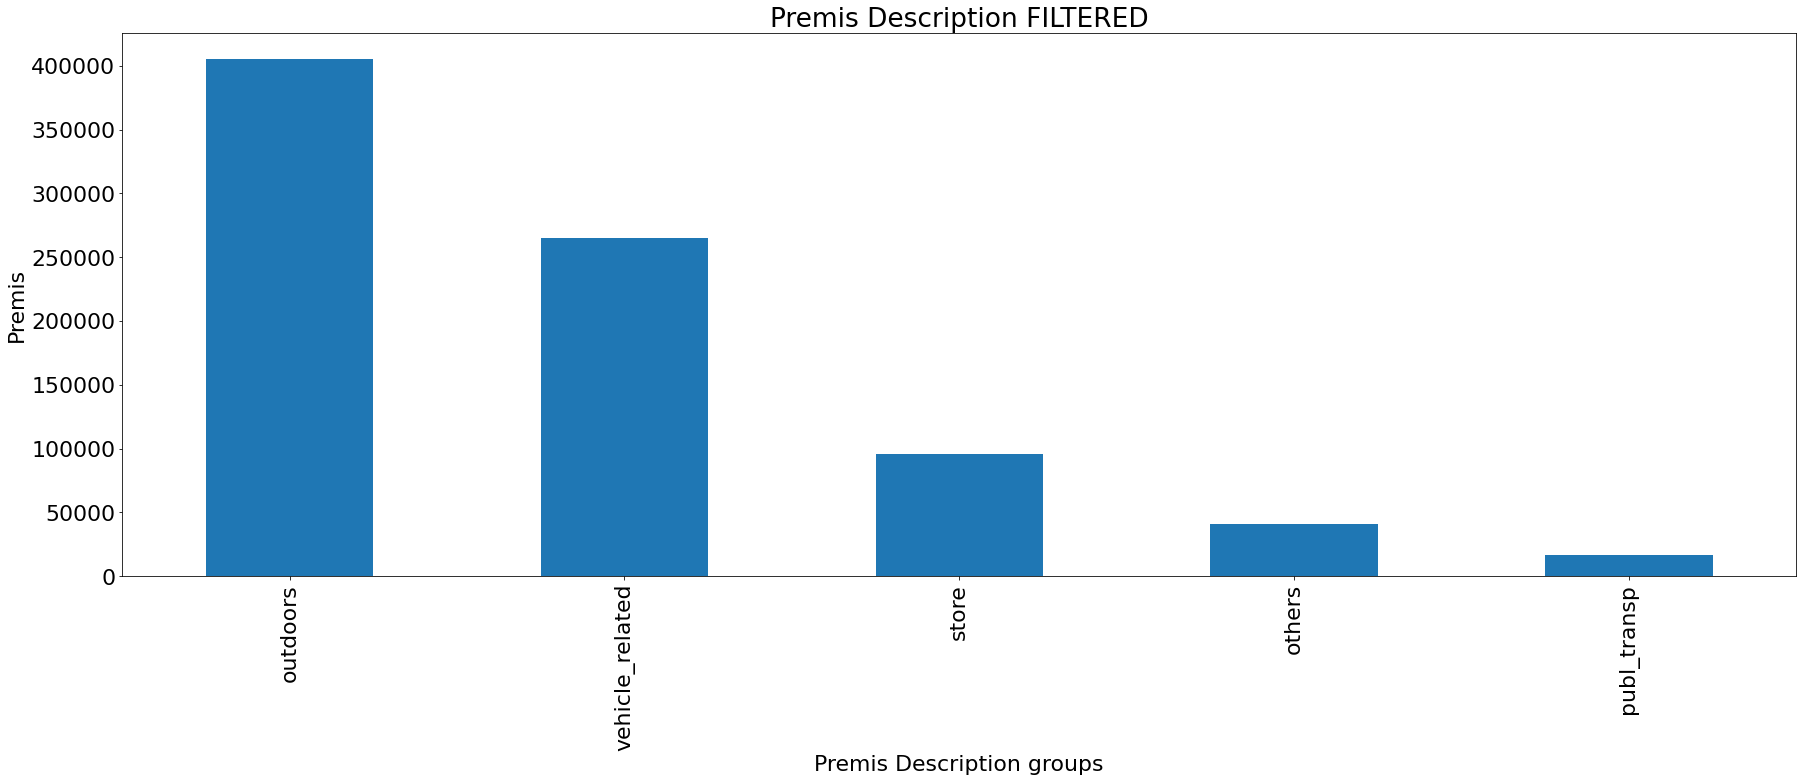

In [48]:
fig = plt.figure()

ax1 = fig.add_subplot(111)
LA_crime["Premis_Desc_FILT"] = LA_crime["Premis_Desc_FILT"].replace({1: "outdoors", 2: "vehicle_related", 3 : "publ_transp", 4 : 'store', 0: "others"})
LA_crime.groupby([LA_crime.Premis_Desc_FILT.rename('Premis_Desc_FILT')])['Premis_Desc_FILT'].agg('count').nlargest(20).plot(kind='bar', figsize=(30,10), )
ax1.set_ylabel('Premis')
ax1.set_xlabel('Premis Description groups')
ax1.set_title("Premis Description FILTERED")
plt.rcParams.update({'font.size': 28})

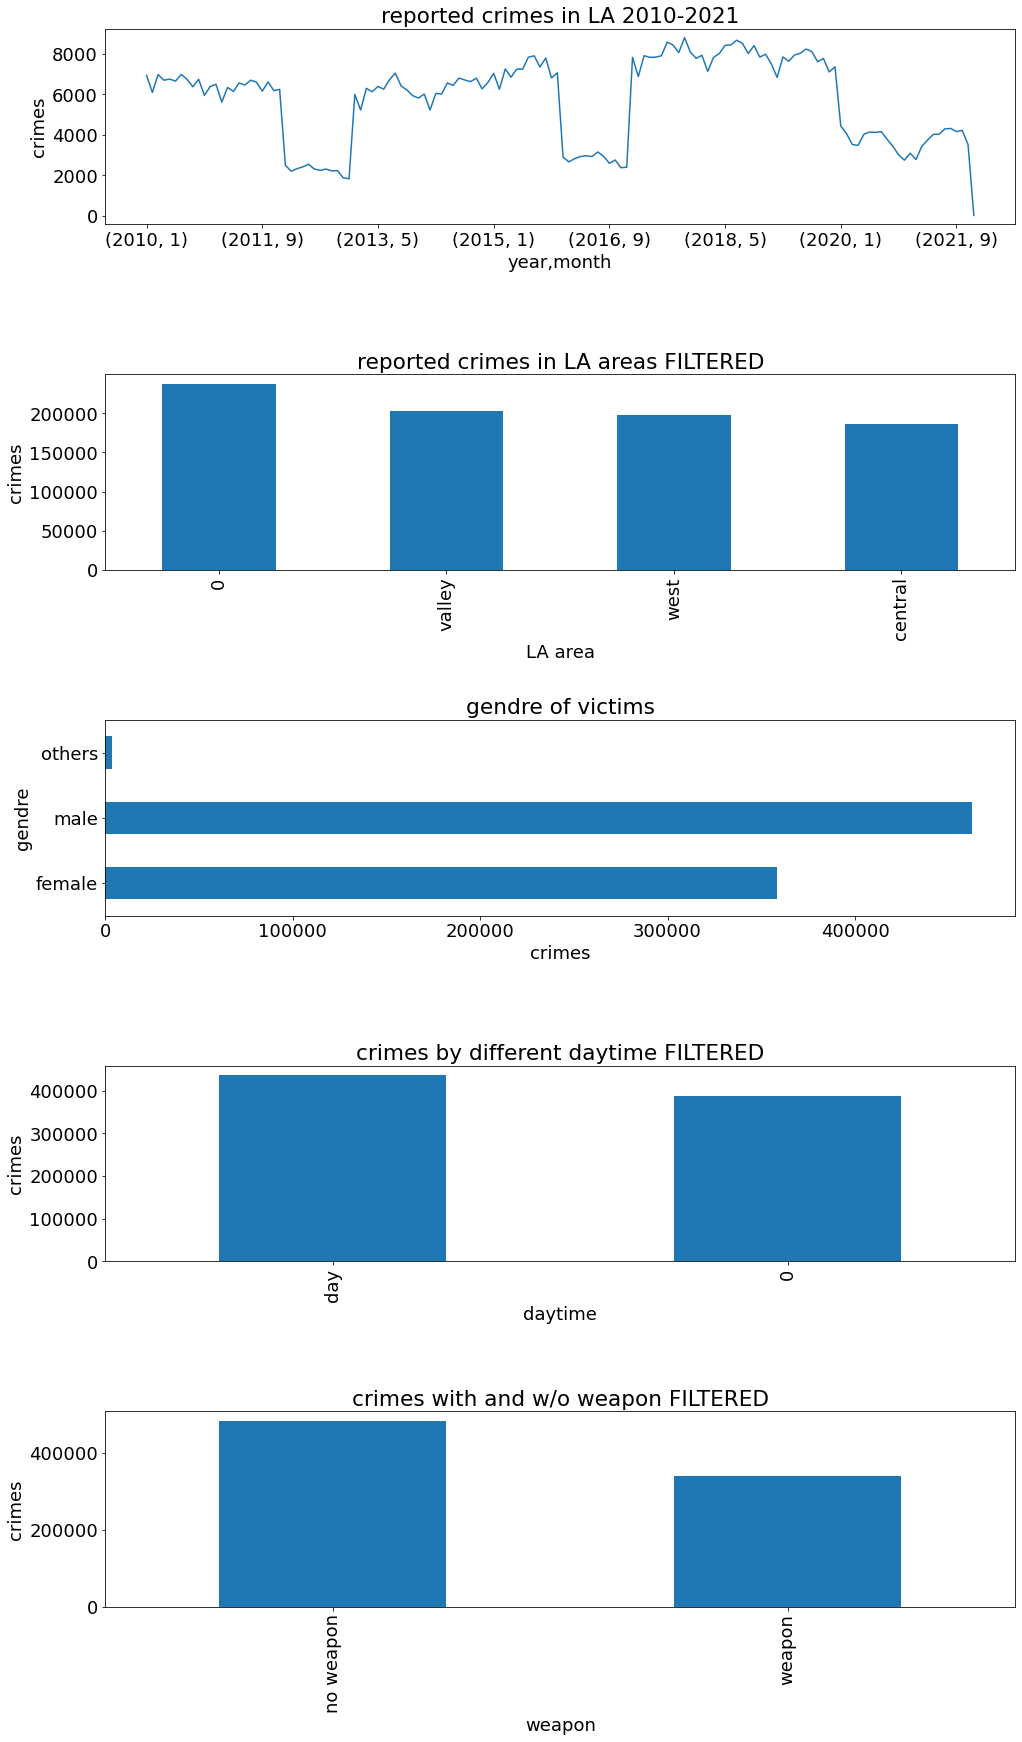

In [72]:
# VISUALISATION GENERAL CRIME REPORT

plt.rcParams.update({'font.size': 18})
LA_crime['DATE_OCC'] = pd.to_datetime(LA_crime['DATE_OCC'])
fig = plt.figure(figsize=(15,25))


ax1 = fig.add_subplot(511)
ax1.set_ylabel('crimes')
ax1.set_xlabel('Years')
ax1.set_title("reported crimes in LA 2010-2021")
#ax1.plot(LA_crime.groupby([LA_crime.DATE_OCC.dt.year, LA_crime.DATE_OCC.dt.month])['DATE_OCC'].agg('count'))
LA_crime.groupby([LA_crime.DATE_OCC.dt.year.rename('year'), LA_crime.DATE_OCC.dt.month.rename('month')])['DATE_OCC'].agg('count').plot(ax=ax1, sharex=False)

LA_crime["AREA_FILT"] = LA_crime["AREA_FILT"].replace({1: "valley", 2: "west", 3 : "central", 4 : "south"})
ax2 = fig.add_subplot(512)
ax2.set_ylabel('crimes')
ax2.set_xlabel('areas in LA')
ax2.set_title("reported crimes in LA areas FILTERED")
LA_crime.groupby([LA_crime.AREA_FILT.rename('LA area')])['AREA_FILT'].agg('count').nlargest(50).plot(kind='bar')

ax3 = fig.add_subplot(513)
LA_crime["Vict_Sex_FILT"] = LA_crime["Vict_Sex_FILT"].replace({1: "male", 2: "female", 0 : "others"})
ax3.set_ylabel('crimes')
ax3.set_xlabel('crimes')
ax3.set_title("gendre of victims")
LA_crime.groupby([LA_crime.Vict_Sex_FILT.rename('gendre')])['Vict_Sex_FILT'].agg('count').plot(kind='barh')

LA_crime["TIME_OCC_FILT"] = LA_crime["TIME_OCC_FILT"].replace({1: "day", 2: "night"})
ax4 = fig.add_subplot(514)
ax4.set_ylabel('crimes')
ax4.set_xlabel('daytime')
ax4.set_title("crimes by different daytime FILTERED")
LA_crime.groupby([LA_crime.TIME_OCC_FILT.rename('daytime')])['TIME_OCC_FILT'].agg('count').nlargest(20).plot(kind='bar')

LA_crime["Weapon_Used_Cd_FILT"] = LA_crime["Weapon_Used_Cd_FILT"].replace({1: "weapon", 0: "no weapon"})
ax4 = fig.add_subplot(515)
ax4.set_ylabel('crimes')
ax4.set_xlabel('')
ax4.set_title("crimes with and w/o weapon FILTERED")
LA_crime.groupby([LA_crime.Weapon_Used_Cd_FILT.rename('weapon')])['Weapon_Used_Cd_FILT'].agg('count').nlargest(20).plot(kind='bar')

fig.tight_layout(pad=2.0)

fig = plt.figure(figsize=(15,20))
LA_crime=LA_crime.drop(LA_crime[LA_crime.Vict_Sex_FILT <1].index)

ax1 = fig.add_subplot(411)
#ax1.set_ylabel('crimes')
#ax1.set_xlabel('Years')
ax1.set_title("destribution of crime according to victim age - male/female")
sns.histplot(data=LA_crime.Vict_Sex_HIST, x=LA_crime.Vict_Age.rename("victim age"), kde=True, hue=LA_crime.Vict_Sex, palette="tab10")

plt.ylabel('crimes')  

Text(0, 0.5, 'crimes')

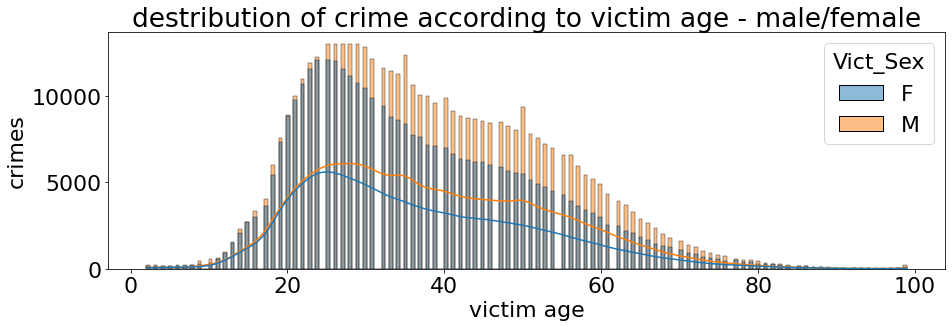

In [250]:
fig = plt.figure(figsize=(15,20))
LA_crime=LA_crime.drop(LA_crime[LA_crime.Vict_Sex_FILT <1].index)

ax1 = fig.add_subplot(411)
#ax1.set_ylabel('crimes')
#ax1.set_xlabel('Years')
ax1.set_title("destribution of crime according to victim age - male/female")
sns.histplot(data=LA_crime.Vict_Sex_HIST, x=LA_crime.Vict_Age.rename("victim age"), kde=True, hue=LA_crime.Vict_Sex, palette="tab10")

plt.ylabel('crimes')  

Weapon_Used_Cd_FILT
Genauigkeit von tree: 0.63
['day', 'night']
Genauigkeit von Ensemble Method: 0.63


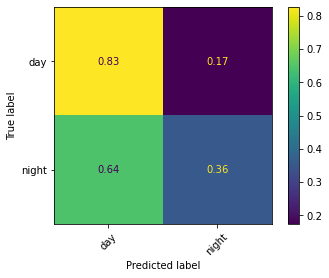

In [47]:
# prediction with age, sex, race

import warnings
warnings.filterwarnings('ignore')

#LA_crime_frac=LA_crime.sample(frac = 0.3, random_state=1)
LA_crime_frac=LA_crime

x_columns=LA_crime_frac[["Vict_Age_FILT", "Vict_Sex_FILT", "Vict_Descent_FILT"]]

y_columns=LA_crime_frac[["TIME_OCC_FILT", "AREA_FILT", "Crm_Cd_Desc_FILT",  "Premis_Desc_FILT", "Weapon_Used_Cd_FILT"]]
y_columns=LA_crime_frac[["Weapon_Used_Cd_FILT"]]

#methods = [('tree',DecisionTreeClassifier())]
methods = [('knn', KNeighborsClassifier()), ('tree',DecisionTreeClassifier()),
           ('forest',RandomForestClassifier()), ('ada',AdaBoostClassifier())]
#methods = [ ('svm',SVC())]

ls_dict=[time_dict, area_dict, crime_dict, premis_dict, weapon_dict]
idx = 0

for (column_name, column_data) in y_columns.iteritems():
    
    print(column_name)
    x_train, x_test, y_train, y_test = train_test_split(x_columns, column_data, test_size=0.25)
    for method in methods:
        if method[0] == "knn_":
            k_range = list(range(15, 31))
            weight_options = ['uniform', 'distance']
            param_grid = dict(n_neighbors=k_range, weights=weight_options)
            grid = GridSearchCV (method[1], param_grid, cv=5, scoring='accuracy', return_train_score=False)
            model =grid.fit(x_train, y_train)
            print(model.best_params_)
        elif method[0] == "tree_":
            crit = ['gini', 'entropy']
            max_d = [2,4,6,8,10,12]
            param_grid = dict(criterion=crit, max_depth=max_d)
            grid = GridSearchCV (method[1], param_grid, cv=5, scoring='accuracy', return_train_score=False)
            model =grid.fit(x_train, y_train)
            print(model.best_params_)
        elif method[0] == "forest_":
            estimators= [100, 200]
            max_feat = ['auto', 'sqrt', 'log2']
            param_grid = dict(n_estimators=estimators, max_features=max_feat)
            grid = GridSearchCV (method[1], param_grid, cv=5, scoring='accuracy', return_train_score=False)
            model =grid.fit(x_train, y_train)
            print(model.best_params_)
        elif method[0] == "svm_":
            param_grid = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01]} 
            grid = GridSearchCV (method[1], param_grid, cv=5, scoring='accuracy', return_train_score=False)
            model =grid.fit(x_train, y_train)
            print(model.best_params_)
        elif method[0] == "ada_":
            estimators= list(range(45, 56))
            rate= [0.9, 1.0, 1.1]
            param_grid = dict(n_estimators=estimators, learning_rate = rate) 
            grid = GridSearchCV (method[1], param_grid, cv=5, scoring='accuracy', return_train_score=False)
            model =grid.fit(x_train, y_train)
            print(model.best_params_)
            
        model = method[1].fit(x_train, y_train)
    
        model_predict = np.round(model.predict(x_test))
        model_accuracy = accuracy_score(model_predict, y_test)
        print("Genauigkeit von {}: {:.02}".format(method[0], model_accuracy))
        labels = list(ls_dict[idx].keys())
        print(labels)
        plot_confusion_matrix(model, x_test, y_test,  normalize="true", xticks_rotation=45)
        plt.xticks( list(ls_dict[idx].values()),  list(ls_dict[idx].keys()))
        plt.yticks( list(ls_dict[idx].values()),  list(ls_dict[idx].keys()))
        plt.show()
    idx=idx+1
    ensemble = VotingClassifier(methods)
    ensemble.fit(x_train, y_train)
    predict = np.round(ensemble.predict(x_test))
    accuracy = accuracy_score(predict,y_test)
    print("Genauigkeit von Ensemble Method: {:.02}".format(accuracy))

    
    


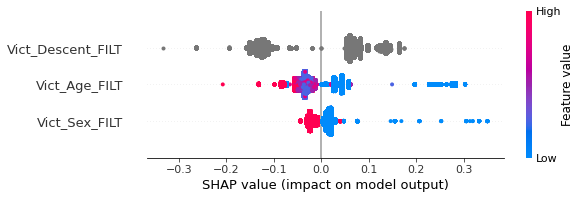

In [49]:
# Initialize JavaScript visualizations in notebook environment
shap.initjs()
# Define a tree explainer for the built model
explainer = shap.TreeExplainer(model)
# obtain shap values for the first row of the test data
shap_values = explainer.shap_values(x_test.iloc[0])
#shap.force_plot(explainer.expected_value[0], shap_values[0], x_test.iloc[0]) 

# obtain shap values for the test data
shap_values = explainer.shap_values(x_test)
#shap.force_plot(explainer.expected_value[0], shap_values[0], x_test) 

shap.summary_plot(shap_values[1], x_test)
#shap.summary_plot(shap_values[1], x_test, plot_type='bar')

In [24]:
idx = 0
for (column_name, column_data) in y_columns.iteritems():
    print(column_name)
    x_train, x_test, y_train, y_test = train_test_split(x_columns, column_data, test_size=0.25)
    x_test_pers = [{'Vict_Age_FILT': 2, 'Vict_Sex_FILT':1, 'Vict_Descent_FILT':1}]
    person = pd.DataFrame(x_test_pers)
    modell_pers= DecisionTreeClassifier().fit(x_train, y_train)
    model_predict = np.round(modell_pers.predict(person))
    dic=ls_dict[idx]
    print(list(dic.keys())[list(dic.values()).index(model_predict)])
    idx=idx+1

TIME_OCC_FILT
night
AREA_FILT
west
Crm_Cd_Desc_FILT
theft
Premis_Desc_FILT
outdoors
Weapon_Used_Cd_FILT
no_weapon


In [90]:

LA_crime.Premis_Desc.unique()
vec=LA_crime.Premis_Desc.value_counts()
vec.to_csv(r'C:\Users\anton\Desktop\Digethik\04_Projektarbeit\premis.csv', sep=';', mode='a')
#LA_crime.groupby([LA_crime.Premis_Desc.rename('Premis_Desc')])['Premis_Desc'].agg('count').nlargest(30).plot(kind='bar', figsize=(20,10))

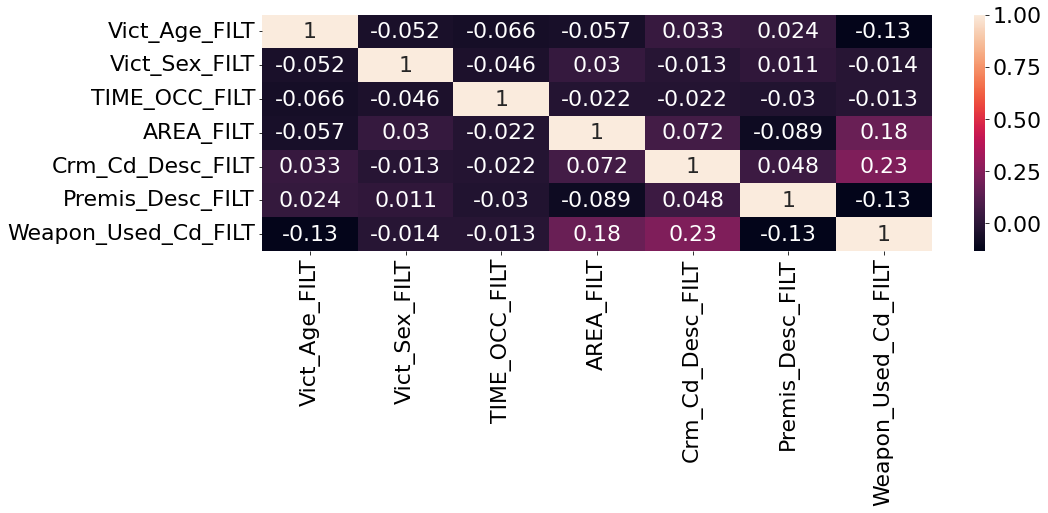

In [255]:
fig = plt.figure(figsize=(15,20))
corr_df=LA_crime[["Vict_Age_FILT", "Vict_Sex_FILT", "Vict_Descent_FILT", "TIME_OCC_FILT", "AREA_FILT", "Crm_Cd_Desc_FILT",  "Premis_Desc_FILT", "Weapon_Used_Cd_FILT"]]

ax1 = fig.add_subplot(411)
dataplot = sns.heatmap(corr_df.corr(), annot=True)

array([[<AxesSubplot:xlabel='Vict_Age_FILT', ylabel='Vict_Age_FILT'>,
        <AxesSubplot:xlabel='Vict_Sex_FILT', ylabel='Vict_Age_FILT'>,
        <AxesSubplot:xlabel='TIME_OCC_FILT', ylabel='Vict_Age_FILT'>,
        <AxesSubplot:xlabel='AREA_FILT', ylabel='Vict_Age_FILT'>,
        <AxesSubplot:xlabel='Crm_Cd_Desc_FILT', ylabel='Vict_Age_FILT'>,
        <AxesSubplot:xlabel='Premis_Desc_FILT', ylabel='Vict_Age_FILT'>,
        <AxesSubplot:xlabel='Weapon_Used_Cd_FILT', ylabel='Vict_Age_FILT'>],
       [<AxesSubplot:xlabel='Vict_Age_FILT', ylabel='Vict_Sex_FILT'>,
        <AxesSubplot:xlabel='Vict_Sex_FILT', ylabel='Vict_Sex_FILT'>,
        <AxesSubplot:xlabel='TIME_OCC_FILT', ylabel='Vict_Sex_FILT'>,
        <AxesSubplot:xlabel='AREA_FILT', ylabel='Vict_Sex_FILT'>,
        <AxesSubplot:xlabel='Crm_Cd_Desc_FILT', ylabel='Vict_Sex_FILT'>,
        <AxesSubplot:xlabel='Premis_Desc_FILT', ylabel='Vict_Sex_FILT'>,
        <AxesSubplot:xlabel='Weapon_Used_Cd_FILT', ylabel='Vict_Sex_FILT'>],
  

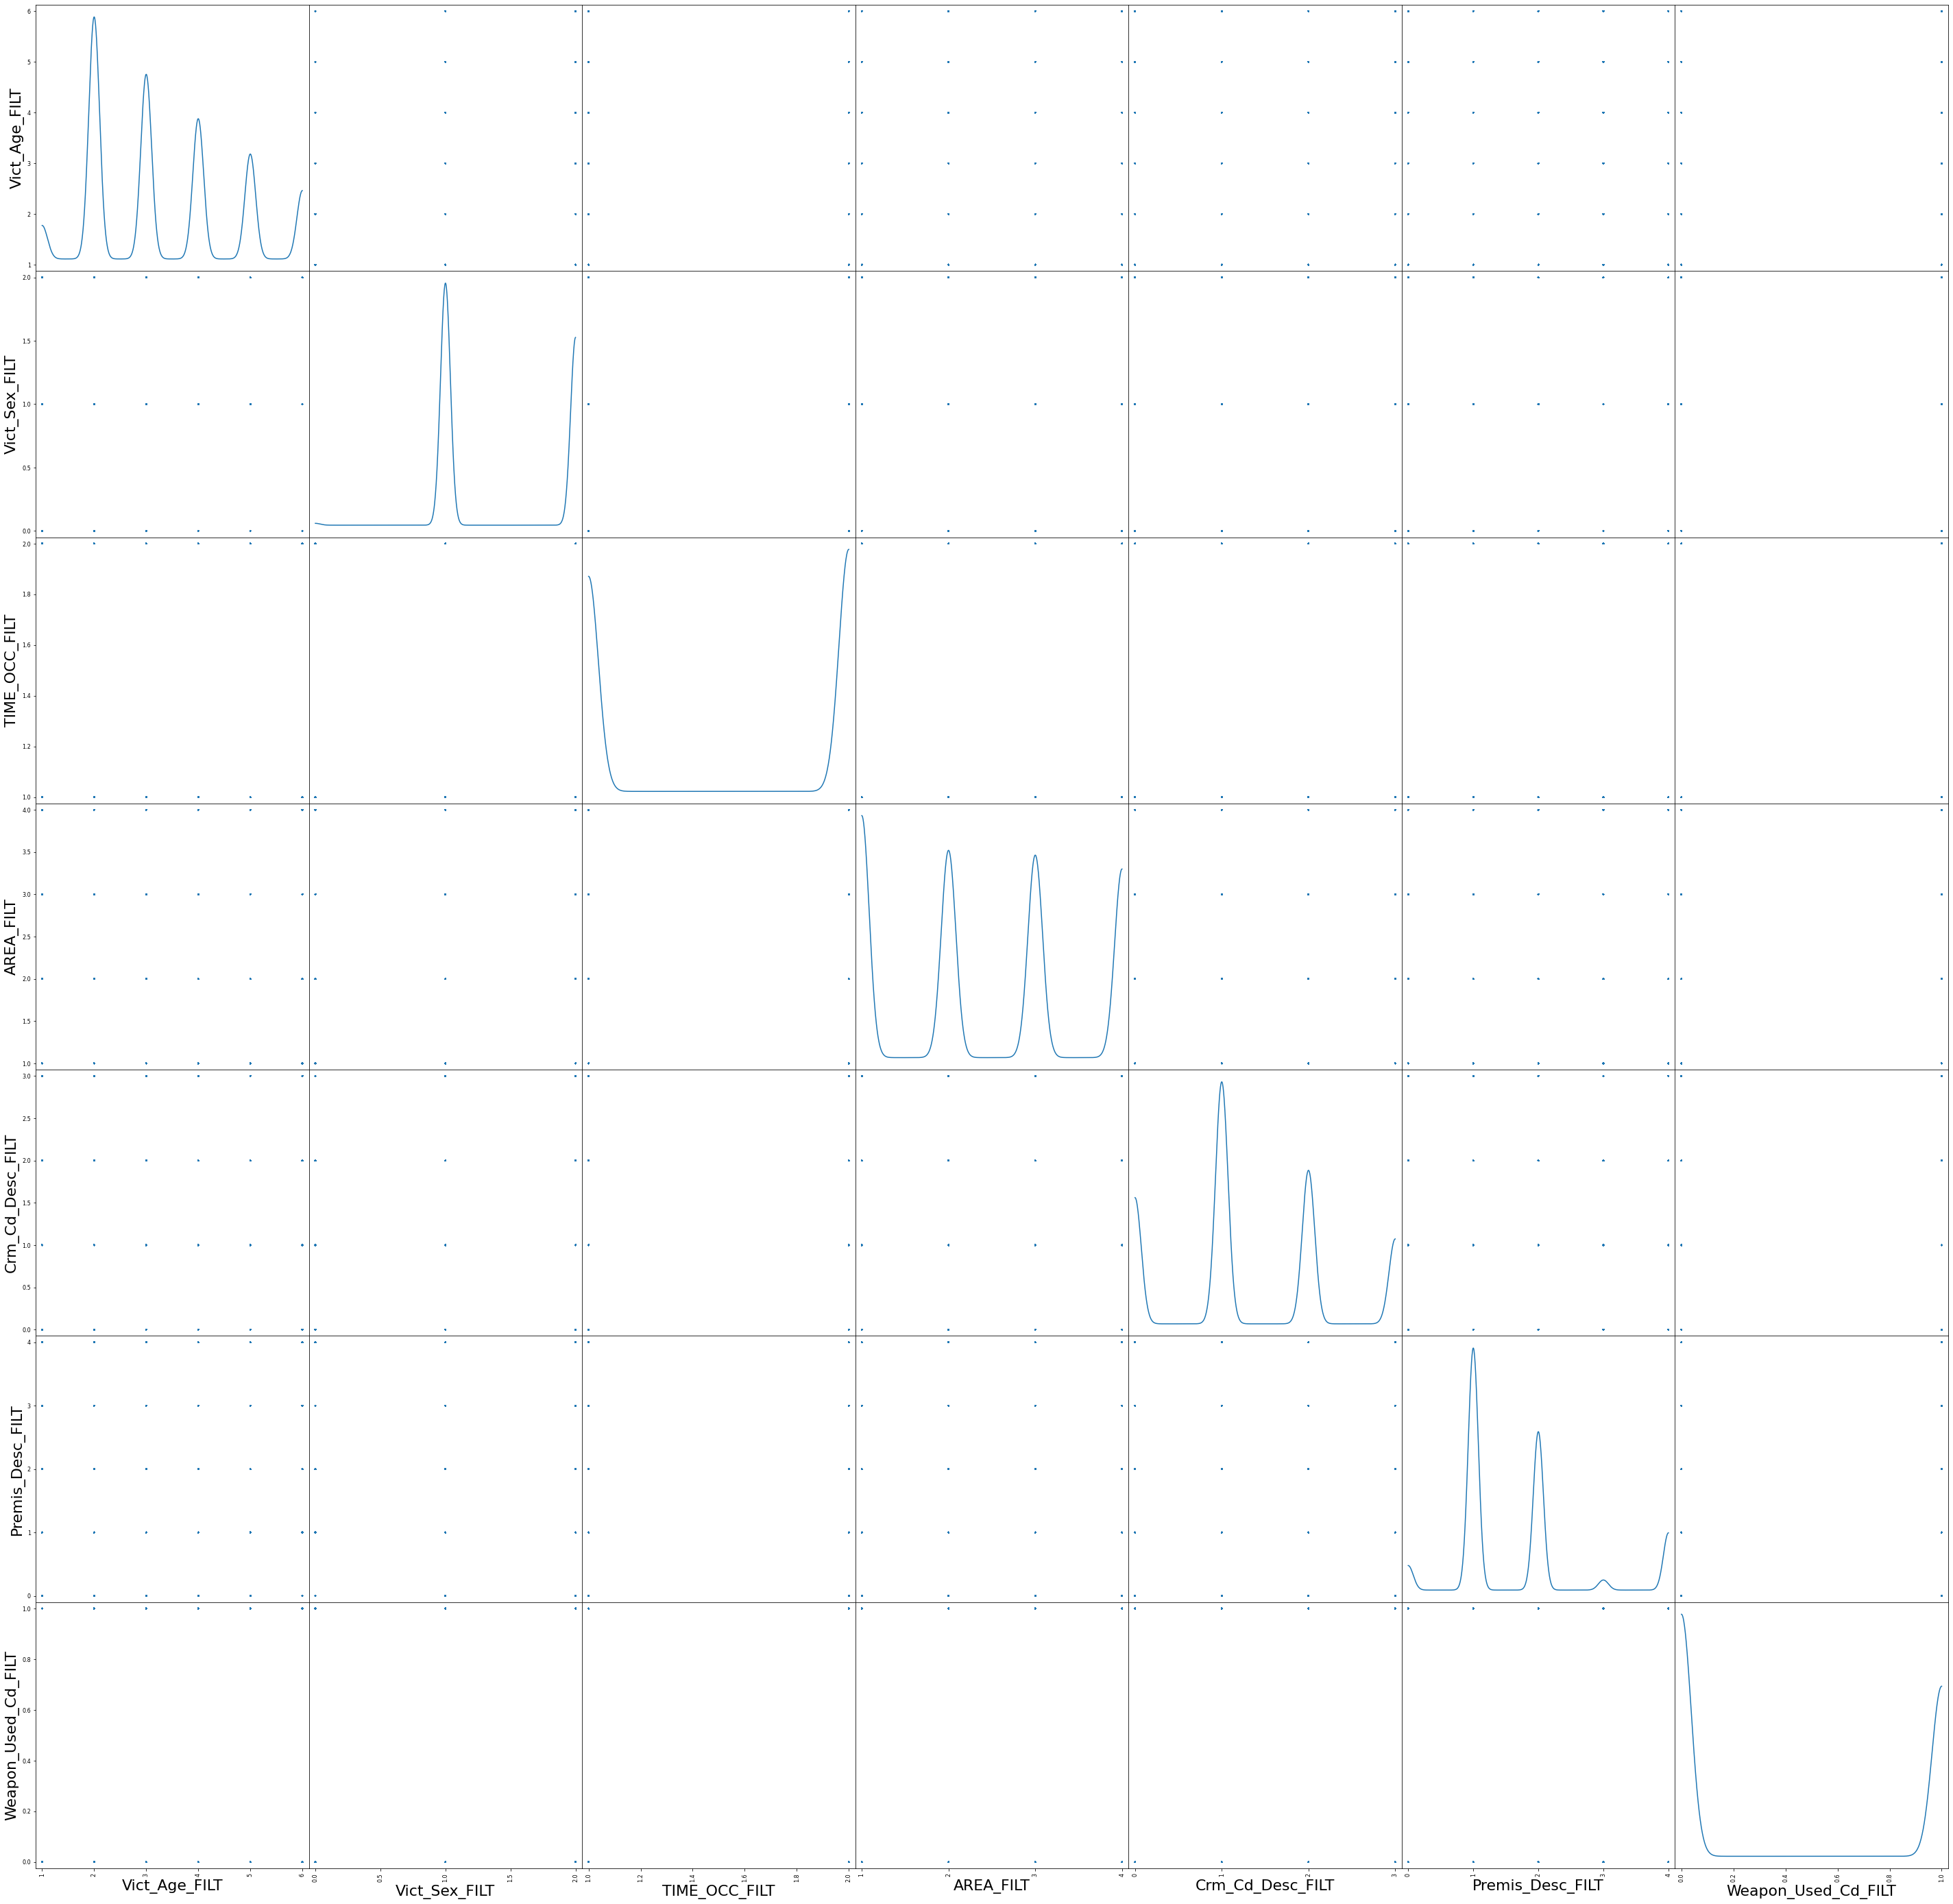

In [257]:

    
pd.plotting.scatter_matrix(corr_df.sample(frac = 0.5, random_state=1), alpha=0.5, figsize=(50, 50), diagonal='kde', s=20)

In [114]:
LA_crime.describe()

,TIME_OCC,AREA_,Crm_Cd,Vict_Age,Vict_Sex,Vict_Descent,Premis_Cd,Weapon_Used_Cd
count,827639.000000,827639.000000,827639.000000,827639.000000,827639.000000,827639.00000,827639.000000,827639.000000
mean,4.231031,10.704644,468.942491,3.308944,0.437389,9.04226,188.431101,204.181681
std,1.715101,6.131303,207.453576,1.385271,0.496065,5.49485,188.076478,147.524492
min,1.000000,1.000000,110.000000,1.000000,0.000000,1.00000,101.000000,100.000000
25%,3.000000,5.000000,330.000000,2.000000,0.000000,7.00000,101.000000,100.000000
50%,5.000000,11.000000,420.000000,3.000000,0.000000,7.00000,104.000000,100.000000
75%,6.000000,16.000000,626.000000,4.000000,1.000000,17.00000,122.000000,400.000000
max,6.000000,21.000000,954.000000,6.000000,1.000000,18.00000,900.000000,516.000000
